<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/PeepholeLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler

# data prepartation

In [51]:
n = 1000        # the number of data points
n_step = 20     # the number of time steps
s1 = np.sin(np.pi * 0.06 * np.arange(n)) + np.random.random(n)
s2 = 0.5*np.sin(np.pi * 0.05 * np.arange(n)) + np.random.random(n)
data = pd.DataFrame({'x1': s1, 'x2':s2})
data

,x1,x2
0,0.341259,0.005277
1,0.200110,0.755724
2,0.449424,0.450488
3,0.910615,0.891776
4,1.326553,0.339424
...,...,...
995,0.163440,-0.129655
996,-0.281756,0.250222
997,-0.154639,0.393909
998,0.098634,0.542212


In [63]:
step = 5

In [64]:
X,y = [] , [] # one to many

for i in range(len(data) - step):         # 1 2 3 4 5
  X.append(data.iloc[i:step+i,:].values)  # 6
  y.append(data.iloc[step+i,:].values)

In [65]:
X = np.array(X)
y = np.array(y)

# Data Splitting

In [66]:
X_train , X_temp , y_train , y_temp = train_test_split(X , y , test_size=0.3 , shuffle=False)
X_val , X_test , y_val , y_test = train_test_split(X_temp , y_temp , test_size=0.5 , shuffle=False)

In [67]:
X_train.shape , X_val.shape , X_test.shape

((696, 5, 2), (149, 5, 2), (150, 5, 2))

# Model

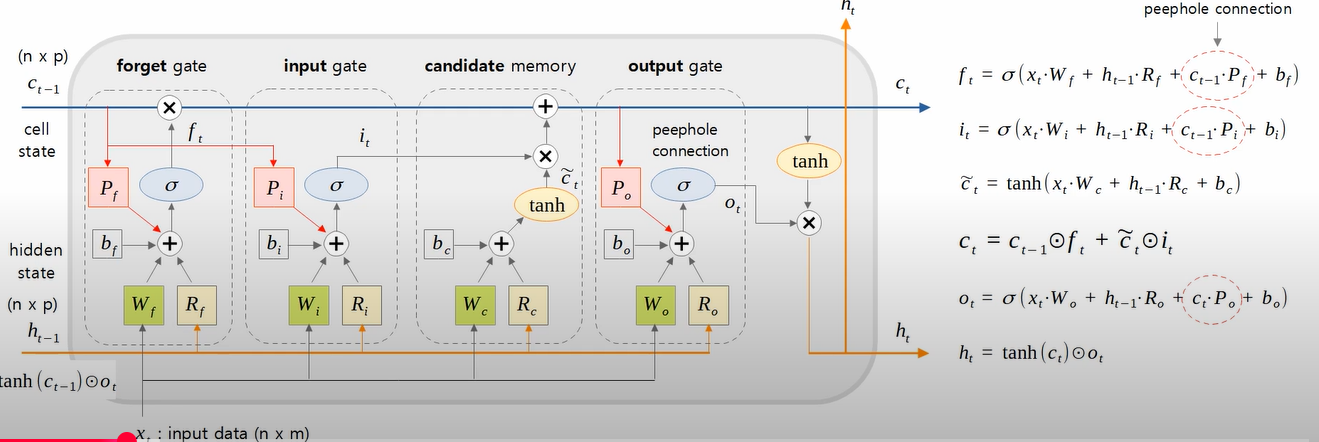

by meanxai

In [82]:
class PeepholeLSTM(Layer):
  def __init__(self,n_hidden):
    super().__init__()
    self.nh = n_hidden

    # weights and bias for x
    self.Wf = Dense(n_hidden)
    self.Wi = Dense(n_hidden)
    self.Wc = Dense(n_hidden)
    self.Wo = Dense(n_hidden)

    # weights for hidden state
    self.Rf = Dense(n_hidden, use_bias=False)  # forget
    self.Ri = Dense(n_hidden, use_bias=False)  # input
    self.Rc = Dense(n_hidden, use_bias=False)  # candidate
    self.Ro = Dense(n_hidden, use_bias=False)  # output

    # weights peephole
    self.Pf = Dense(n_hidden, use_bias=False)
    self.Pi = Dense(n_hidden, use_bias=False)
    self.Po = Dense(n_hidden, use_bias=False)

  def lstm_cell(self ,x,h,c):
    f_gate = tf.math.sigmoid(self.Wf(x) + self.Rf(h) + self.Pf(c))
    i_gate = tf.math.sigmoid(self.Wi(x) + self.Ri(h)+ self.Pi(c))
    c_gate = tf.math.tanh(self.Wc(x) + self.Rc(h))
    c_stat = c * f_gate + (i_gate * c_gate)
    o_gate = tf.math.sigmoid(self.Wo(x) + self.Ro(h)+ self.Po(c_stat))
    h_stat = tf.math.tanh(c_stat) * o_gate

    return h_stat,c_stat

  def call(self,x):
    h = tf.zeros(shape=(tf.shape(x)[0], self.nh))
    c = tf.zeros(shape=(tf.shape(x)[0], self.nh))

    #time_step loop
    for t in range(x.shape[1]):
        h, c = self.lstm_cell(x[:, t, :], h, c)
    return h





In [83]:
# Create an LSTM model
n_features = X_train.shape[-1]
n_output = y_train.shape[-1]
n_hidden = 50

x_input = Input(batch_shape=(None, step, n_features))
h = PeepholeLSTM(n_hidden)(x_input) #LSTM(50)
y_output = Dense(n_output)(h) #Dense(2)
model = Model(x_input, y_output)


model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()   # Trainable params: 10,702


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5, 2)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ peephole_lstm_2 (PeepholeLSTM)       │ (None, 50)                  │          18,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,202 (71.10 KB)

 Trainable params: 18,202 (71.10 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=64, verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.4960 - val_loss: 0.2524
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2345 - val_loss: 0.1797
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1874 - val_loss: 0.1636
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1632 - val_loss: 0.1644
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1562 - val_loss: 0.1581
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1631 - val_loss: 0.1512
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1465 - val_loss: 0.1467
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1456 - val_loss: 0.1427
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1417 - val_loss: 0.1395
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1483 - val_loss: 0.1350
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1351 - val_loss: 0.1331
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1356 - v

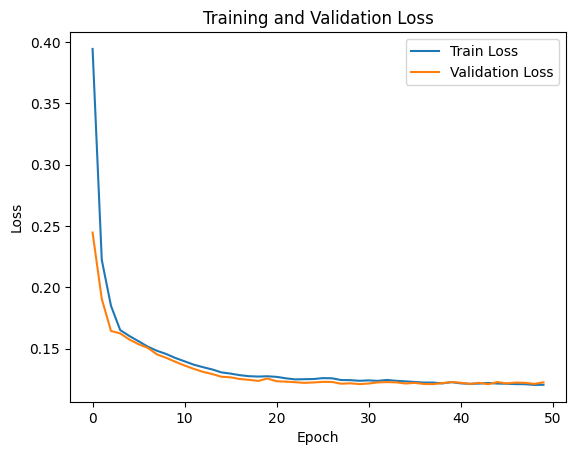

In [81]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
